# Importing Libraries

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import tensorflow as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface

import keras.backend as K

import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from scipy import ndimage

import numpy as np

import flowpm
from flowpm.kernels import fftk
from flowpm import linear_field, lpt_init, nbody, cic_paint
import flowpm.tfpm as tfpm
import flowpm.utils as pmutils

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Global simulation parameters

In [3]:
bs = 64 #simulation box size in Mpc/h
nc = 64 #particle number sidelength (i.e. nc**3 is number of particles in sim)

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data/Planck15_a1p00.txt').T[1]
# fiducial cosmology function
ipklin = iuspline(klin, plin)

np.random.seed(0)

# Helper Functions
### i) Global power spectra helper functions

In [4]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    #print(dig.size,xsum.size,len((W * kmag).flat))
    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [5]:
def pk(field, kmin=5, dk=0.8, shape = False, boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [6]:
def pk_func(inputs):
    nc = inputs.shape[1] #assume equal dimensions right now
    ic = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    pkr = pk(tf.squeeze(ic,0),shape = ic.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)
    with tf.Session() as sess:
        pk_out = sess.run((pkr),{ic: inputs})
    return pk_out

### ii) Defining optimization-related helper functions 

In [7]:
#variable noise... in this case masking the edges and including variable noise over image
a = numpy.arange(64)
numpy.random.shuffle(a)
noise_prop = np.ones((nc,nc,nc))*0.01
inv_sigma = (1/noise_prop)
def likelihood_fn(inputs, b, predictions, inv_sigma = inv_sigma):
    """ Evaluates the data chi-squared function through Fast PM
    """
    _,final_field = pm(predictions[..., 0],b)

    clipped1 = final_field
    clipped2 = inputs[...,0]
    likelihood = tf.reduce_sum((clipped1-clipped2)**2*inv_sigma**2, 
                              axis=[1, 2, 3])
    return likelihood, final_field

def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """
    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

In [8]:
def pm(lin,b):
    ''' Evolution operator, NOTE: this is using all the tensorflow tensors, need to use a tf.Session() to evaluate them.
    '''
    state = flowpm.lpt_init(lin, a0=0.1)
    final_state = flowpm.nbody(state, stages, nc)
    final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
    return  final_field, tf.math.exp(-1*(0.20+b[0])*final_field**(b[1]+1.8))#(0.90+0.1*b[0])*final_field + (0.20+0.1*b[1])*final_field**2.0#tf.math.exp(-(0.22+b[0]*0.0001)*final_field**(1.8+b[1]*0.0001))

In [9]:
class TARDIS:
    def __init__(self, isLyaReconstruction = [False, ], prior_v = [0.0,0.0]):
        self.prior_v = prior_v
        self.isLyaReconstruction = isLyaReconstruction
        self.__init__model()
    def __init__model(self):
        self.xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
        if (self.isLyaReconstruction[0] == False):
            self.yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data
        else:
            self.skewers_fin = self.isLyaReconstruction[1]
            self.yy = tf.placeholder(tf.float32, [self.skewers_fin.shape[0]]) #lya flux

        self.bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

        self.linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
        self.initlin_op = self.linearkk.assign(self.xx, name='initlin_op')

        linear_wc = tfpm.r2c3d(self.linearkk, norm=nc**3, name=None)
        linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
        self.linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 

        # Compute the likelihood fn
        if (self.isLyaReconstruction[0] == False):
            self.likelihood, self.final_field = likelihood_fn(tf.expand_dims(self.yy, -1), self.bias, tf.expand_dims(self.linear,-1)) 
        else:
            self.inverse_covar = self.isLyaReconstruction[2]
            self.final_field, self. evolved_field_FGPA = pm(self.linear, self.bias)
            # No RSD stuff for now...
            #evolved_field_FGPA = K.exp(-1.0*self.RSD_tau)#fgpa(self.evolved_field,bias_lya)
            #evolved_field_FGPA = np.exp(-b1*sim2**b2)

            # No smoothing for now...
            #evolved_field_FGPA_sm = smoothing(evolved_field_FGPA, Rsm, kmesh, nc)
        
            self.flux_val = flowpm.cic_readout(self.evolved_field_FGPA, np.array(self.skewers_fin,dtype=np.float32).reshape(1,-1,3))
            self.likelihood_lya = likelihood_fn_lya(self.flux_val, self.yy, self.inverse_covar)
            self.likelihood = reduce_sum_det(self.likelihood_lya)
            
        # Compute the prior on field
        prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

        # Compute the prior on the parameters
        prior_values = tf.constant(self.prior_v)
        prior_2 = tf.reduce_sum((prior_values-self.bias)**2.0) #rough gaussian prior...

        prior_total = tf.reduce_sum(prior_1)+prior_2

        self.logposterior = tf.reduce_mean(self.likelihood) +  tf.reduce_mean(prior_total)

In [10]:
def optimize(T, variable, data, maxiter, starting_point = np.random.randn(1,nc,nc,nc), gtol=1e-12, sigma=1.0, isLyaReconstruction = False):
    opt = ScipyOptimizerInterface(T.logposterior, var_list=variable, method='L-BFGS-B',
                                                    options={'maxiter': maxiter, 'gtol':gtol})
    sess.run(tf.global_variables_initializer())

    batchsize = 1
    # Initialize gradient descent at random point
    sess.run(T.initlin_op, {T.xx: starting_point});
    st = time.time()
    #opt.minimize(sess, {T.yy:data[0:1]})
    if (isLyaReconstruction == False): opt.minimize(sess, {T.yy:data[0:1]})
    else: opt.minimize(sess, {T.yy:data})
    print("Total Time:", time.time()-st)

# Making Initial Density Field...

In [11]:
# Set initial conditions
initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)

with tf.Session() as sess:
    linear_true = sess.run((initial_conditions))

In [12]:
stages = np.linspace(0.1, 0.3, 1, endpoint=True) ## 0.3 when using lyman alpha forest
ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

# Sample particles
state = flowpm.lpt_init(ic, a0=0.1)   

# Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, nc)         

# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(ic), final_state[0])

# Calculate power spectra for intial density field
pkr_ic = pk(tf.squeeze(ic,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)

# Calculate power spectra for final density field
pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)
        
with tf.Session() as sess:
    sim, pkr_ic0, pkr_out = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [13]:
#setting up prior for model
kvec = fftk((nc, nc, nc), symmetric=False)
kmesh = sum((kk / bs * nc)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.797151


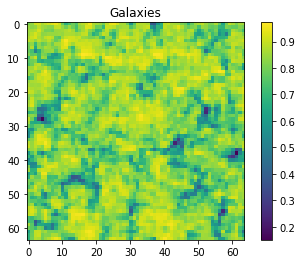

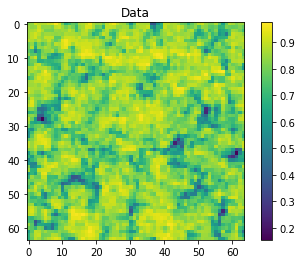

In [14]:
#True Bias Values...
b1=.22
b2=1.8

noise_real = np.random.randn(nc,nc,nc)*noise_prop
sims2 = sim #ndimage.gaussian_filter(sim,0.2,mode="wrap")
gal= np.exp(-b1*sims2**b2)
data = gal + noise_real

print(np.mean(gal))
title("Flux")
imshow(gal[0,4])
colorbar()
show()

title("Data")
imshow(data[0,4])
colorbar()

In [15]:
tf.reset_default_graph()
sess = tf.Session()   
T = TARDIS()
# 1st optimization: Just optimize density field
optimize(T,[T.linearkk], data, maxiter = 100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 4325171.500000
  Number of iterations: 101
  Number of functions evaluations: 108
Total Time: 24.77863049507141


In [16]:
test, inp, fins, bf = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data[0:1]})

In [17]:
# 2nd optimizatiton: Optimized Density field + Bias Parameters
optimize(T, [T.linearkk,T.bias], data, starting_point = inp, maxiter = 100)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3624133.750000
  Number of iterations: 13
  Number of functions evaluations: 29
Total Time: 10.70547366142273


In [18]:
test, inp_i, fins, bf = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data[0:1]})

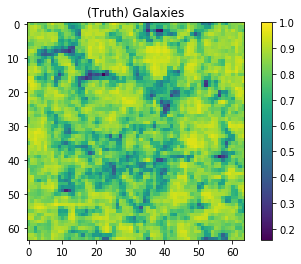

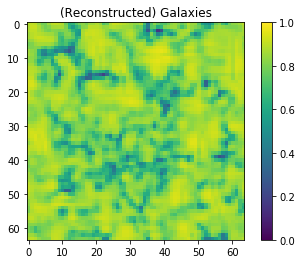

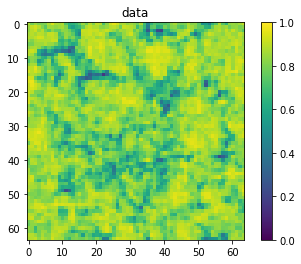

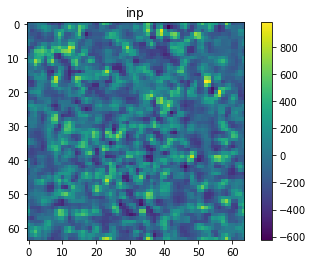

In [19]:
slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow((fins[0][slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp[0,slic])
colorbar()
show()


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


[1.2460336e+03 2.4255080e+02 8.7344849e+01 4.1972069e+01 1.2149317e+01
 2.6358228e+00 5.2310658e-01 1.0475280e-01 1.9333834e-02 3.7691926e-03
 9.3061576e-04 2.2771966e-04]
[ 0.02238153 -0.12573305]


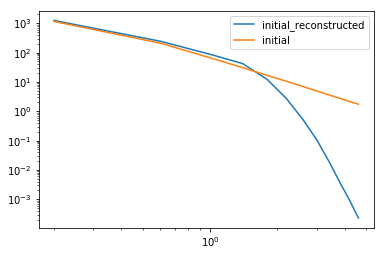

In [20]:
# Calculate and plot true and initial power spectra
reconstructed_pk = pk_func(test)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])
print(bf)

# Lyman-α skewer reconstruction

### Helper functions

In [21]:
def gen_noise(nzpix, n_skewers, snr_min, snr_max, alpha):
    #generates noise according to specified distribution
    snr = numpy.minimum(snr_min/numpy.random.power(alpha-1,size=n_skewers),snr_max)
    skewers_noise = (1.0/snr[:,numpy.newaxis])*numpy.ones(nzpix)
    return snr, skewers_noise

def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def reduce_sum_det(x):
    #deterministic reduce sum
    v = tf.reshape(x, [1, -1])
    return tf.reshape(tf.matmul(v, tf.ones_like(v), transpose_b=True), [])

### Create Lyman-α skewer sample

In [64]:
# skewer properties
n_skewers = 1000 #test w 4000
snr_min = 10 #2
snr_max = 10 #10
alpha = 2.8
sm = 1.0
  
#power law distribution of noise with high snr cutoff
snr, noise_level = gen_noise(nc, n_skewers, snr_min, snr_max, alpha)

In [23]:
# Select skewers
x = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
y = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
z = np.arange(0, nc)
        
pos = np.vstack([x,y])
skewers_pos = []
for i in pos.T:
    skewers_pos.append(np.hstack([i*np.ones((nc,2)),z.reshape(1,-1).T]))
    
#final skewer data positions
skewers_fin = np.array(np.vstack(skewers_pos),dtype=int)
        
#flux values at each point 
#### Should be RSD (not sim)
vals_lya = gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()

noise_variance = numpy.array([abs(i)*numpy.ones(nc) for i in noise_level]).flatten()
# The inverse covar must be of type float32.
noise_variance = noise_variance.astype(np.float32)
indices = [(i, i) for i in range(len(noise_variance))]
inverse_covar = tf.SparseTensorValue(indices, noise_variance**-1, [len(noise_variance), len(noise_variance)])
       
vals_observed = ndimage.gaussian_filter1d(vals_lya, sm) + n

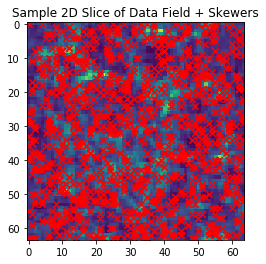

In [24]:
# Plot sample skewers
title("Sample 2D Slice of Data Field + Skewers")
imshow(sim[0,20,:,:])
plot(skewers_fin[::20][:,0],skewers_fin[::20][:,1],"rx")
show()

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5]),
 <a list of 10 Patch objects>)

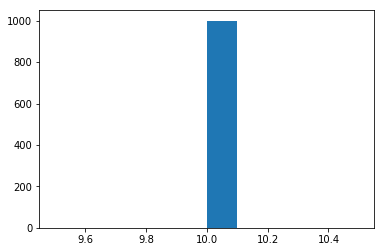

In [25]:
# Plot SNR distribution of skewers
plt.hist(1/noise_level[:,0])

### Running the reconstruction

In [26]:
tf.reset_default_graph()
sess = tf.Session()   
T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])

# LOOP 1: Just optimize density field
optimize(T,[T.linearkk], vals_observed, maxiter = 1000, isLyaReconstruction = True)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61761.960938
  Number of iterations: 570
  Number of functions evaluations: 609
Total Time: 122.13458323478699


In [27]:
test_lya, inp_lya, fins_lya, bf_lya = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})

In [28]:
# LOOP 2: Optimized Density field + Bias Parameters
optimize(T, [T.linearkk,T.bias], vals_observed, starting_point = inp_lya, maxiter = 1000, isLyaReconstruction = True)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57165.867188
  Number of iterations: 13
  Number of functions evaluations: 31
Total Time: 12.824487209320068


In [29]:
test_lya, inp_i_lya, fins_lya, bf_lya = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})

In [30]:
#recon_linear, recon_evolved, recon_gal = sess.run([linear, evolved_field, flux_val],
#          {xx:starting_point, yy_lya:vals_observed})
#test, inp, fins, bf,flux_out = sess.run([linear,linearkk, final_field,bias,flux_val], {xx:starting_point,yy_lya:vals_observed})
#flux_out = sess.run([flux_val], {xx:starting_point,yy_lya:vals_observed})

In [31]:
print(bf_lya)

[-0.00823839  1.6840283 ]


In [32]:
#skewers_in = vals_observed.reshape(-1,64)
#skewers_out = flux_out.reshape(-1,64)
#skewers_true = vals_lya.reshape(-1,64)
#plot(skewers_out[10])
#plot(skewers_in[10])
#plot(skewers_true[10])

In [131]:
print(fins_lya.shape)

(1, 64, 64, 64)


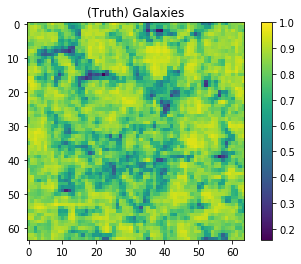

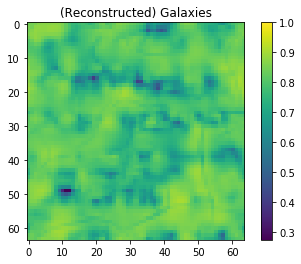

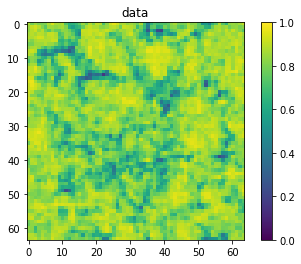

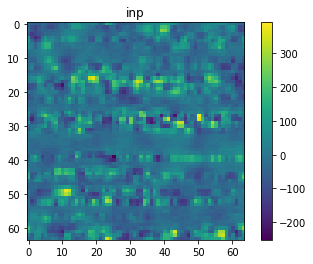

In [132]:
slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow(np.exp(-b1*fins_lya**b2)[0][slic], vmax = 1)
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp_lya[0,slic])
colorbar()
show()

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


[8.2255164e+02 8.5128967e+01 1.2768910e+01 2.5793908e+00 6.8345797e-01
 2.0167775e-01 6.5728277e-02 2.2440655e-02 7.6510836e-03 2.6983763e-03
 9.9833310e-04 4.0208816e-04]


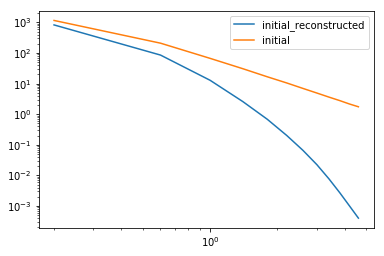

In [34]:
reconstructed_pk = pk_func(test_lya)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

## Injecting power

### Helper functions

In [35]:
def evolve_injected(ic,smwts):
    ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

    datak = tfpm.r2c3d(ic, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)

    # Sample particles
    state = flowpm.lpt_init(dataf, a0=0.1)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, nc)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(dataf), final_state[0])
    pkr_ic = pk(tf.squeeze(dataf,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4) #0.001, 0.05

    pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4) #0.05
        
    with tf.Session() as sess:
        sim_mode, pkr_ic_mode, pkr_out_mode = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})
    return sim_mode, pkr_ic_mode, pkr_out_mode

### Rerunning the reconstructions

In [65]:
delta = 0.06
modes = np.linspace(0.01, max(pkr_ic0[0]), reconstructed_pk[0].size)

In [66]:
N = modes.size
print(N)
filts = np.empty(shape=(N,), dtype=object)

for i in range(0, N, 1):
    filts[i] = np.logical_and(kmesh<modes[i]+delta,kmesh>modes[i]-delta)*2 + 1

fisher_matrix = np.zeros((N, N))

12


In [67]:
reconstructed_extra_power_fields= np.empty(shape=(N,), dtype=object)
true_extra_power_fields = np.empty(shape=(N,), dtype=object)
true_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_bf = np.empty(shape=(N,), dtype=object)

In [68]:
for i in range(0, N, 1):
    print("N=",i)
    st = time.time()  
    tf.reset_default_graph()
    #----------------------------------------------------------
    
    smwts = filts[i]
    #apply transfer function to intial conditions
    sim_mode, pkr_ic_mode, pkr_out_mode = evolve_injected(ic,smwts)
    true_extra_power_fields[i] = linear_true
    true_initial_mode_pks[i] = pkr_ic_mode
    
    sims2_mode = sim_mode
    gal_mode= np.exp(-1*b1*sims2_mode**b2)
    
    #flux values at each point 
    #### Should be RSD (not sim)
    vals_lya_mode = gal_mode[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

    #add noise
    n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()       
    vals_observed = ndimage.gaussian_filter1d(vals_lya_mode, sm) + n
    #----------------------------------------------------------
    
    sess = tf.Session()   
    T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])

    # LOOP 1: Just optimize density field
    optimize(T,[T.linearkk], vals_observed, maxiter = 1000, isLyaReconstruction = True)
    test_lya_mode, inp_lya_mode, fins_lya_mode, bf_lya_mode = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})
    
    # LOOP 2: Optimized Density field + Bias Parameters
    optimize(T, [T.linearkk,T.bias], vals_observed, starting_point = inp_lya_mode, maxiter = 1000, isLyaReconstruction = True)
    test_lya_mode, inp_i_lya_mode, fins_lya_mode, bf_lya_mode = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})
    #----------------------------------------------------------
    
    # Calculate and save reconstructed power spectra
    reconstructed_pk_mode = pk_func(test_lya_mode)
    reconstructed_initial_mode_pks[i] = reconstructed_pk_mode
    reconstructed_bf[i] = bf_lya_mode
    
    print(i,time.time()-st)
    
#np.save('initial_reconstructed_w_extra_power_pks_lya', reconstructed_initial_mode_pks)
#np.save('initial_true_w_extra_power_pks_lya', true_initial_mode_pks)
#np.save('linear_reconstructed_w_extra_power_fields_lya', reconstructed_extra_power_fields)
#np.save('linear_true_w_extra_power_fields_lya', true_extra_power_fields)

N= 0


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61545.312500
  Number of iterations: 441
  Number of functions evaluations: 467
Total Time: 93.27906584739685
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56989.613281
  Number of iterations: 14
  Number of functions evaluations: 24
Total Time: 11.749385595321655


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


0 119.24962019920349
N= 1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62753.585938
  Number of iterations: 533
  Number of functions evaluations: 562
Total Time: 117.09841203689575
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58732.585938
  Number of iterations: 14
  Number of functions evaluations: 27
Total Time: 12.853651523590088


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


1 144.6010823249817
N= 2
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 63541.539062
  Number of iterations: 543
  Number of functions evaluations: 562
Total Time: 122.10775637626648
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58791.960938
  Number of iterations: 12
  Number of functions evaluations: 21
Total Time: 12.185822248458862


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


2 149.88842487335205
N= 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61984.640625
  Number of iterations: 540
  Number of functions evaluations: 551
Total Time: 122.09352278709412
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57131.769531
  Number of iterations: 14
  Number of functions evaluations: 22
Total Time: 12.607090473175049


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


3 150.64204168319702
N= 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62965.808594
  Number of iterations: 525
  Number of functions evaluations: 550
Total Time: 122.59370517730713
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58180.578125
  Number of iterations: 14
  Number of functions evaluations: 20
Total Time: 12.438332796096802


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


4 151.49175763130188
N= 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62769.363281
  Number of iterations: 456
  Number of functions evaluations: 469
Total Time: 107.30702662467957
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58239.250000
  Number of iterations: 14
  Number of functions evaluations: 23
Total Time: 12.970952987670898


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


5 136.51992344856262
N= 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62673.550781
  Number of iterations: 459
  Number of functions evaluations: 471
Total Time: 107.96343326568604
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57995.714844
  Number of iterations: 13
  Number of functions evaluations: 24
Total Time: 13.230009078979492


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


6 137.79618859291077
N= 7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62592.984375
  Number of iterations: 462
  Number of functions evaluations: 473
Total Time: 109.65558171272278
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58608.066406
  Number of iterations: 13
  Number of functions evaluations: 20
Total Time: 12.765434503555298


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


7 138.8463077545166
N= 8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61608.820312
  Number of iterations: 550
  Number of functions evaluations: 561
Total Time: 128.72506046295166
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56903.238281
  Number of iterations: 13
  Number of functions evaluations: 27
Total Time: 14.038581609725952


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


8 159.6905574798584
N= 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61794.921875
  Number of iterations: 491
  Number of functions evaluations: 509
Total Time: 118.8998031616211
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57252.378906
  Number of iterations: 13
  Number of functions evaluations: 19
Total Time: 12.905577182769775


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


9 149.05002546310425
N= 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62296.230469
  Number of iterations: 437
  Number of functions evaluations: 456
Total Time: 107.00443530082703
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 57954.183594
  Number of iterations: 14
  Number of functions evaluations: 24
Total Time: 13.594695568084717


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


10 137.7257843017578
N= 11
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61346.824219
  Number of iterations: 438
  Number of functions evaluations: 448
Total Time: 105.71970868110657
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56863.859375
  Number of iterations: 14
  Number of functions evaluations: 24
Total Time: 13.643076658248901


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


11 136.34056067466736


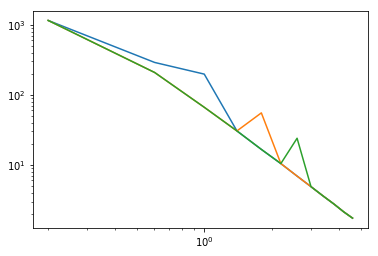

In [69]:
# sample of 3 input modes, should look like 3 little bumps
# plotting true_initial_mode_pks[i]:
plt.loglog(true_initial_mode_pks[2][0],true_initial_mode_pks[2][1])
plt.loglog(true_initial_mode_pks[4][0],true_initial_mode_pks[4][1])
plt.loglog(true_initial_mode_pks[6][0],true_initial_mode_pks[6][1])

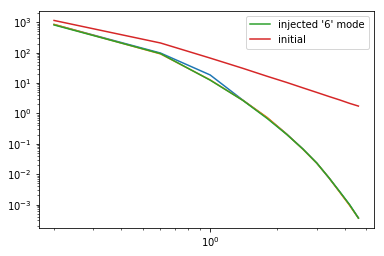

In [70]:
# Plotting the 3 respective reconstructed power spectra
plt.loglog(reconstructed_initial_mode_pks[2][0],reconstructed_initial_mode_pks[2][1])
plt.loglog(reconstructed_initial_mode_pks[4][0],reconstructed_initial_mode_pks[4][1])
plt.loglog(reconstructed_initial_mode_pks[6][0],reconstructed_initial_mode_pks[6][1], label = 'injected \'6\' mode')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
plt.legend()

In [71]:
#calculating average reconstructed PS to reduce noise... could also just run the first part of the code a few dozen times...
pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,12,3)]
pk_c = np.median(np.array(pks),axis = 0)

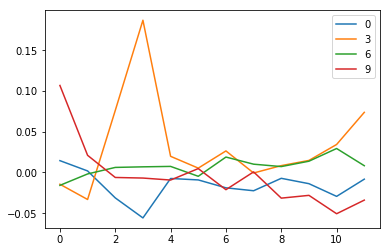

In [72]:
#response of little bumps
for i in range(0,12,3):
    plot(np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:],label=str(i))
legend()
#ylim(-5,5)

In [73]:
print(reconstructed_bf[1])

[-0.00971591  1.35591   ]


In [96]:
tf.reset_default_graph()
# Add variation to Bias Values
b1_new= b1+delta

# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1_new*sims2_new**b2)
new_data = new_gal + noise_real

#flux values at each point 
#### Should be RSD (not sim)
new_vals_lya = new_gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()       
new_vals_observed = ndimage.gaussian_filter1d(new_vals_lya, sm) + n

######## LOOP 1: Just optimize density field
sess = tf.Session()   
T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])
optimize(T,[T.linearkk],new_vals_observed,starting_point =inp, maxiter = 1000, isLyaReconstruction = True)

#test, inp_i, fins, bf 
test_1, inp_1, fins_1, bff_1 = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_vals_observed})    
print(bff_1)

###### LOOP 2: Optimized Density field + Bias Parameters

optimize(T,[T.linearkk,T.bias],new_vals_observed,starting_point =inp_1, maxiter = 1000, isLyaReconstruction = True)

inp_1, test_1, fins_1, bff_1= sess.run([T.linearkk,T.linear, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_vals_observed})    

print(bff_1)
#########

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64036.218750
  Number of iterations: 523
  Number of functions evaluations: 547
Total Time: 112.64036536216736
[0. 0.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58865.949219
  Number of iterations: 15
  Number of functions evaluations: 25
Total Time: 12.646444320678711
[0.02720965 1.1069452 ]


In [98]:
tf.reset_default_graph()

b2_new= b2+delta

# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1*sims2_new**b2_new)
new_data = new_gal + noise_real


#flux values at each point 
#### Should be RSD (not sim)
new_vals_lya = new_gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()       
new_vals_observed = ndimage.gaussian_filter1d(new_vals_lya, sm) + n

######## LOOP 1: Just optimize density field

sess = tf.Session()   
T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])
optimize(T,[T.linearkk],new_vals_observed,starting_point =inp, maxiter = 1000, isLyaReconstruction = True)

#test, inp_i, fins, bf 
test_2, inp_2, fins_2, bff_2 = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:new_data[0:1],T.yy:new_vals_observed})    
print(bff_2)

####### LOOP 2: Optimized Density field + Bias Parameters

optimize(T,[T.linearkk,T.bias],new_vals_observed,starting_point =inp_1, maxiter = 1000, isLyaReconstruction = True)

inp_2, test_2, fins_2, bff_2= sess.run([T.linearkk,T.linear, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_vals_observed})    

print(bff_2)

#########

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62245.292969
  Number of iterations: 427
  Number of functions evaluations: 440
Total Time: 95.88497638702393
[0. 0.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72887.992188
  Number of iterations: 9
  Number of functions evaluations: 18
Total Time: 11.474762678146362
[ 0.00673833 -0.42234623]


In [99]:
reconstructed_bft = np.array([i for i in reconstructed_bf[:]])
bl = [reconstructed_bft[:,0].mean(),reconstructed_bft[:,1].mean()]

In [100]:
bff_1,bff_2

(array([0.02720965, 1.1069452 ], dtype=float32),
 array([ 0.00673833, -0.42234623], dtype=float32))

In [101]:
bl = [reconstructed_bft[:,0].mean(),reconstructed_bft[:,1].mean()]

In [102]:
(bff_1 - bl)/0.06, (bff_2 - bl)/0.06

(array([ 0.6220071, -8.836655 ], dtype=float32),
 array([  0.2808184, -34.324844 ], dtype=float32))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


[1.2092241e+03 1.1654189e+02 1.4992478e+01 3.0218630e+00 7.6962125e-01
 2.2842143e-01 7.1480840e-02 2.4170419e-02 7.5522619e-03 2.5308379e-03
 9.0627489e-04 3.2696122e-04]


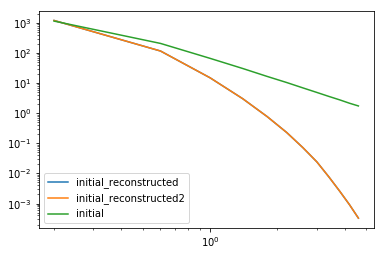

In [104]:
reconstructed_pk = pk_func(test_1)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
reconstructed_pk_ii = pk_func(test_2)
plt.loglog(reconstructed_pk_ii[0], reconstructed_pk_ii[1], label = 'initial_reconstructed2')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

[]

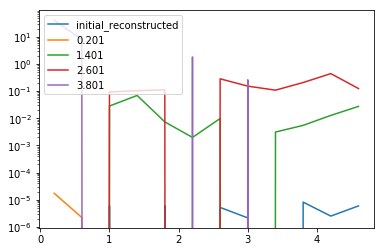

In [105]:
#response of little bumps
plt.plot(reconstructed_pk[0], np.array(reconstructed_pk[1]-reconstructed_pk_ii[1])[0:]/reconstructed_pk_ii[1]/0.06/3, label = 'initial_reconstructed')

for i in range(0,12,3):
    plot(reconstructed_pk[0],np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:]/pk_c[i],label=str(reconstructed_pk[0][i]))
legend()

semilogy()

In [106]:
np.array(reconstructed_pk[1]-reconstructed_pk_ii[1])[0:]/reconstructed_pk_ii[1]/0.06

array([-1.6824880e-06,  0.0000000e+00,  1.8022905e-05, -6.5748209e-06,
        1.8070923e-05, -6.5235367e-06,  1.5634792e-05,  6.4219198e-06,
       -3.2884480e-05,  2.4532692e-05,  7.4931977e-06,  1.7802638e-05],
      dtype=float32)

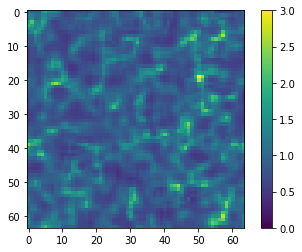

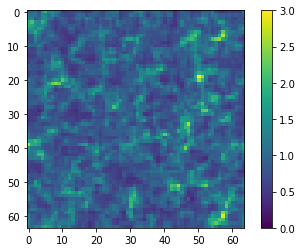

In [107]:
imshow(np.exp((np.log(-1*np.log(fins)/b1)/b2))[0,0],vmax=3,vmin=0)
colorbar()
show()
imshow(sim[0,0],vmax=3,vmin=0)
colorbar()


In [108]:
reconstructed_pk_1 = pk_func(test_1)
reconstructed_pk_2 = pk_func(test_2)

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


# Calculating the Fisher Matrix

In [109]:
pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,12,3)]
pk_c = np.median(np.array(pks),axis = 0)



#MODES:

#b_l Eq (4.41)

b_l = pk_c - pkr_ic0[1]

#eq (4.21) and 4.46

#delta theta = pk_c[i]*2

F_ll = np.array([(np.array(reconstructed_initial_mode_pks[i][1]- b_l)/pkr_ic0[1])/(pk_c[i]*2) for i in range(0,N)])

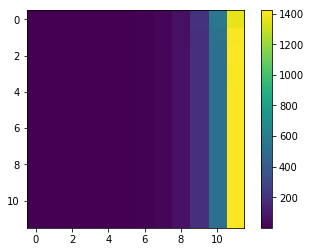

In [110]:
imshow(np.array(F_ll).T)
colorbar()

In [111]:
# Modes x Parameters

reconstructed_bft = np.array([i for i in reconstructed_bf])
b_p = [np.median(reconstructed_bft[:,0]),np.median(reconstructed_bft[:,1])]

F_lp = np.array([(reconstructed_bft[i]-b_p)/(pk_c[i]*2) for i in range(0,N)])

In [112]:
# parameters x modes...

F_pl = [(np.array(reconstructed_pk_1[1]- b_l)/pkr_ic0[1])/0.06,(np.array(reconstructed_pk_2[1]- b_l)/pkr_ic0[1])/0.06,]

F_pp = [(bff_1 - b_p)/0.06, (bff_2 - b_p)/0.06]

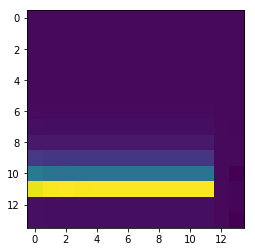

In [113]:
imshow(np.vstack([np.hstack([F_ll,F_lp]),np.hstack([F_pl,F_pp])]))

In [133]:
F_tt = np.nan_to_num(np.vstack([np.hstack([F_ll,F_lp]),np.hstack([F_pl,F_pp])]))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


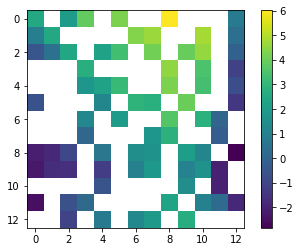

In [134]:
imshow(np.log10(np.linalg.inv(F_tt[1:,1:].T)))
colorbar()

In [116]:
1/np.sqrt(np.diag(F_tt))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([4.0585148e+01, 1.1107991e+01, 4.7665458e+00, 2.2929344e+00,
       1.1598079e+00, 6.3851327e-01, 3.6283082e-01, 2.1395725e-01,
       1.2241941e-01, 7.1845978e-02, 4.3892629e-02, 2.6588624e-02,
       1.2687905e+00,           nan], dtype=float32)

In [117]:
np.sqrt(np.diag(np.linalg.inv(F_tt[1:,1:].T)))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([17.848993 , 17.916552 , 17.391514 , 23.84626  , 13.684112 ,
              nan,        nan,  8.06206  ,        nan,  3.496557 ,
              nan,  1.3467023,        nan], dtype=float32)

In [118]:
#eq 5.3

#derivatives are equal to zero for initial bandpowers, so only matter for forward model parameters

#inverse FGPA
sim_var = np.exp((np.log(-1*np.log(fins)/b1)/b2))
       
new_gal_1= np.exp(-b1*sim_var**b2)

new_gal_2= np.exp(-(b1+delta)*sim_var**b2)

partial_b1 = (new_gal_2-new_gal_1)/delta
                 
                 
new_gal_1= np.exp(-b1*sim_var**b2)

new_gal_2= np.exp(-(b1)*sim_var**(b2+delta))

partial_b2 = (new_gal_2-new_gal_1)/delta
                 
#eq 5.4

res = data- fins

Gl_1 = np.sum(partial_b1 * res*inv_sigma)
Gl_2 = np.sum(partial_b2 * res*inv_sigma)

In [119]:
F_tt[-1,-1] += Gl_2
F_tt[-2,-2] += Gl_1

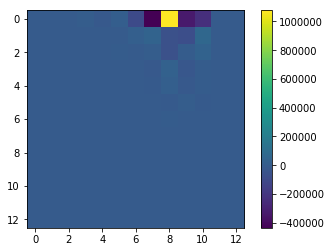

In [120]:
imshow(np.linalg.inv(F_tt[1:,1:].T))
colorbar()

In [121]:
err_norm = 1/np.sqrt(np.diag(F_tt))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [122]:
err_marg = np.sqrt(np.diag(np.linalg.inv(F_tt[:,:].T)))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [123]:
for i,_ in enumerate(err_norm):
    print(err_norm[i],err_marg[i])

40.585148 nan
11.107991 17.899044
4.766546 18.230694
2.2929344 15.175819
1.1598079 21.081758
0.63851327 10.718212
0.36283082 19.638882
0.21395725 nan
0.12241941 27.571896
0.07184598 nan
0.04389263 15.431148
0.026588624 nan
nan nan
nan nan


In [124]:
np.std(reconstructed_bft[:,0]),np.std(reconstructed_bft[:,1])

(0.0013118627, 0.10485693)

<ErrorbarContainer object of 3 artists>

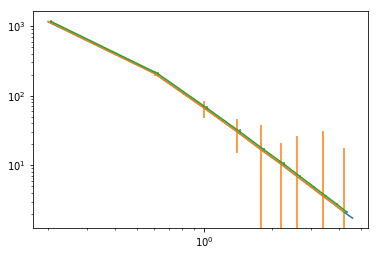

In [125]:
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1],reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1],yerr=err_marg[:-3])
plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1]*1.03,reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1],yerr=err_norm[:-3])

#After marginalization... small scale error explode!


In [107]:
#np.save("lya_err_marg", err_marg)
#np.save("lya_true_initial_pk_x",pkr_ic0[0])
#np.save("lya_true_initial_pk_y",pkr_ic0[1])
#np.save("lya_reconstructed_initial_pk_x", reconstructed_initial_mode_pks[0][0][:-1])
#np.save("lya_reconstructed_initial_pk_y", reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1])

In [126]:
#covariance matrix for parameters!
np.linalg.inv(F_tt[:,:].T)[-2:,-2:]

array([[-1.1705516e-02, -8.9542584e-05],
       [ 1.4154078e-03, -3.1045072e-02]], dtype=float32)